In [2]:
import os
import pickle

import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
pd.options.display.max_columns = 100
%matplotlib inline

In [3]:
def get_predictions(set_type, path = '../data/model/'):
    """Concat all feature set model predictions for a particular set
    
    Args:
        set_type: string 'train, test or dev'
        path: model data folder
    """
    assert set_type in ['train', 'test', 'dev']
    df = pd.read_csv(path + set_type +'.csv', encoding='latin1')
    df.set_index('full_set_id', inplace = True)
    suffix = "_" + set_type + '.csv'
    files = [x for x in os.listdir(path + 'model_predictions/') if x.endswith(suffix)]
    for file in files:
        df_preds = pd.read_csv(path + 'model_predictions/' + file, 
                               encoding='latin1', 
                               index_col = 0)
        assert df_preds.shape[1] == 1
        col = "_".join(file.split("_")[:-1])
        df_preds.columns = ['m_' + col]
        df = pd.concat([df, df_preds], axis = 1)
    df.dropna(subset = ['broke_from_party'], inplace = True)
    return df
df_train = get_predictions('train') 
df_dev = get_predictions('dev')
df_test = get_predictions('test')

Let's look at the correlations between the feature set models. We want it to be positive, but not an extremely high value, which indicates the same underlying force is driving both predictions.

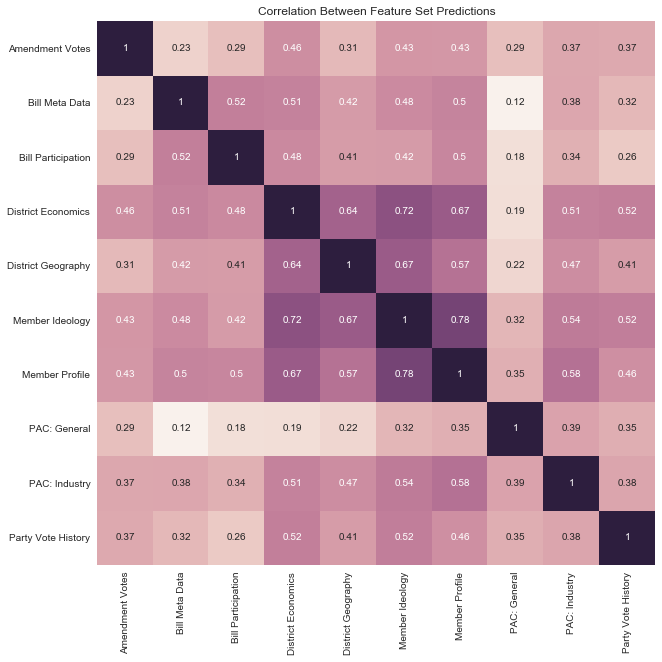

In [4]:
labels = {'m_amendment_votes': 'Amendment Votes', 
         'm_bill_info': 'Bill Meta Data', 
         'm_bill_involvement': 'Bill Participation', 
         'm_ideology': 'Member Ideology', 
         'm_member_demos': 'Member Profile', 
         'm_pac_general': 'PAC: General', 
         'm_pac_industry': 'PAC: Industry', 
         'm_votes_party': 'Party Vote History', 
          'm_district_econ': 'District Economics', 
          'm_district_geo': 'District Geography'}
plt.rcParams['figure.figsize']=(10,10)
model_preds = [x for x in df_train.columns if x.startswith('m_')]
ax = sns.heatmap(df_train[model_preds].corr(), annot=True, cbar=False)
ax.set_title('Correlation Between Feature Set Predictions')
labels_list = [labels[x] for x in model_preds]
ax.set_xticklabels(labels_list)
ax.set_yticklabels(reversed(labels_list))
# plt.savefig('cor.jpg')

In [5]:
def score_features():
    """Score Feature sets"""
    features = [x for x in df_train.columns if x.startswith('m_')]
    output = []
    for feature in features:
        stats = {}
        rows = df_train[feature].isnull() == False
        
        # find threshold that results in rate of party split consistent with train set
        rate = df_train.loc[rows,['broke_from_party']].mean()[0] 
        rows = df_dev[feature].isnull() == False
        model_dev = df_dev[rows]
        threshold = np.percentile(model_dev[feature], 100 - rate*100)
        stats['feature'] = feature
        stats['threshold'] = threshold
        
        y_pred = model_dev[feature] >= threshold
        y_true = model_dev.broke_from_party
        
        stats['precision'] = metrics.precision_score(y_true, y_pred)
        stats['recall'] = metrics.recall_score(y_true, y_pred)
        stats['f1'] = metrics.f1_score(y_true, y_pred)
        stats['f1_weighted'] = metrics.f1_score(y_true, y_pred, average = 'weighted')
        
        #get baseline stats
        t = [1] * int(len(model_dev) * rate)
        t += ([0] *(len(model_dev) - len(t)))
        t = shuffle(t)
        stats['bl_precision'] = metrics.precision_score(y_true, t)
        stats['bl_recall'] = metrics.recall_score(y_true, t)
        stats['bl_f1'] = metrics.f1_score(y_true, t)
        stats['bl_f1_weighted'] = metrics.f1_score(y_true, t, average = 'weighted')
        
        output.append(stats)
    return output
scores = score_features()
scores = pd.DataFrame(scores)

In [6]:
scores.sort_values('f1', ascending = True, inplace = True)
scores['Feature Set'] = scores.feature.apply(lambda x: labels[x])
scores

,bl_f1,bl_f1_weighted,bl_precision,bl_recall,f1,f1_weighted,feature,precision,recall,threshold,Feature Set
7,0.043125,0.919097,0.043016,0.043236,0.145824,0.927778,m_pac_general,0.145444,0.146205,0.111283,PAC: General
2,0.054729,0.899062,0.054488,0.054972,0.245850,0.919446,m_bill_involvement,0.244633,0.247080,0.162527,Bill Participation
4,0.054866,0.895920,0.054622,0.055111,0.267993,0.919388,m_district_geo,0.266792,0.269205,0.163700,District Geography
9,0.051479,0.898456,0.051292,0.051667,0.291628,0.924164,m_votes_party,0.290565,0.292698,0.693289,Party Vote History
1,0.052842,0.898649,0.052568,0.053119,0.294395,0.924415,m_bill_info,0.292279,0.296541,0.814705,Bill Meta Data
8,0.030408,0.935620,0.030400,0.030416,0.298706,0.953431,m_pac_industry,0.298587,0.298826,0.625997,PAC: Industry
3,0.042672,0.928827,0.042904,0.042443,0.354474,0.952006,m_district_econ,0.356366,0.352602,0.195632,District Economics
6,0.054061,0.898530,0.053788,0.054338,0.412370,0.936965,m_member_demos,0.410276,0.414485,0.231838,Member Profile
0,0.089131,0.831810,0.088568,0.089702,0.418616,0.892641,m_amendment_votes,0.415922,0.421345,0.260180,Amendment Votes
5,0.057345,0.895278,0.057029,0.057665,0.475264,0.941705,m_ideology,0.472631,0.477927,0.250716,Member Ideology


In [7]:
scores.to_csv('scores.csv', index = False)

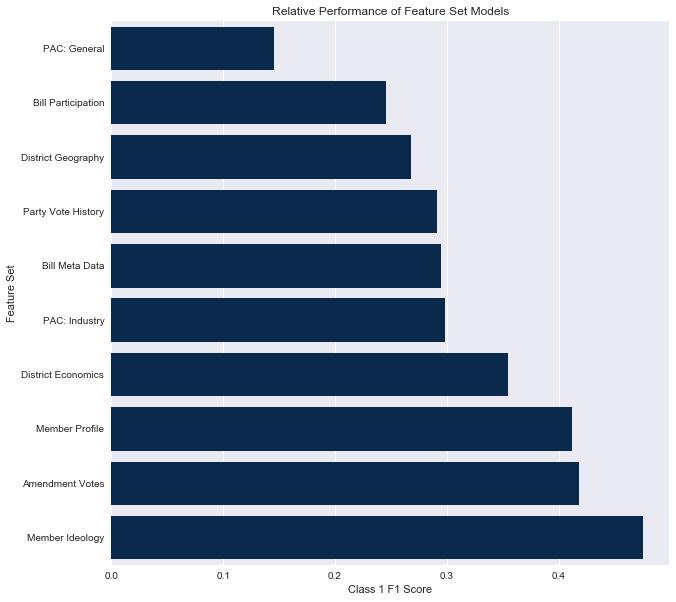

In [8]:
ax = sns.barplot(data=scores, x = 'f1', y = 'Feature Set', color = '#002855')
ax.set_title('Relative Performance of Feature Set Models')
ax.set_xlabel('Class 1 F1 Score')
plt.savefig('bar2.jpg')

In [70]:
397975 / 494803

0.8043099981204641

In [9]:
model_train = df_train.fillna(-1)
model_dev = df_dev.fillna(-1)
model_test = df_test.fillna(-1)
features = [x for x in df_train.columns if x.startswith('m_')]
# rfc = RandomForestClassifier(class_weight='balanced', min_samples_split=40)
# rfc.fit(model_train[features], model_train['broke_from_party'])

C:\Users\Steve\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


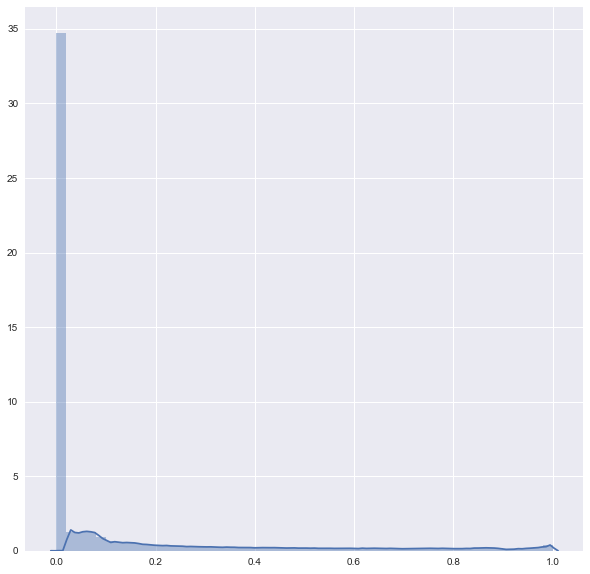

In [97]:
probs_dev = rfc.predict_proba(model_dev[features])[:,1]
probs_train = rfc.predict_proba(model_train[features])[:,1]
sns.distplot(probs_dev)

In [98]:
thresh = .71
print((probs_dev >= thresh).sum())
print(metrics.classification_report(model_dev['broke_from_party'], probs_dev >= thresh, digits=4))

25263
             precision    recall  f1-score   support

          0     0.9696    0.9719    0.9708    468404
          1     0.4798    0.4591    0.4692     26399

avg / total     0.9435    0.9446    0.9440    494803



In [100]:
scores

,bl_f1,bl_f1_weighted,bl_precision,bl_recall,f1,f1_weighted,feature,precision,recall,threshold,Feature Set
3,0.054142,0.894922,0.053843,0.054444,0.430927,0.936773,m_ideology,0.428463,0.433420,0.780931,Member Ideology
0,0.091171,0.832187,0.090595,0.091754,0.414287,0.891598,m_amendment_votes,0.409978,0.418689,0.719276,Amendment Votes
4,0.054061,0.898530,0.053788,0.054338,0.374149,0.932865,m_member_demos,0.372250,0.376069,0.750887,Member Profile
6,0.034142,0.935868,0.034133,0.034152,0.298706,0.953431,m_pac_industry,0.298587,0.298826,0.625997,PAC: Industry
1,0.054127,0.898786,0.053846,0.054410,0.294395,0.924415,m_bill_info,0.292279,0.296541,0.814705,Bill Meta Data
7,0.053574,0.898680,0.053380,0.053770,0.291628,0.924164,m_votes_party,0.290565,0.292698,0.693289,Party Vote History
2,0.052784,0.898855,0.052552,0.053018,0.238826,0.918705,m_bill_involvement,0.237693,0.239969,0.761174,Bill Participation
5,0.040856,0.918905,0.040752,0.040960,0.145824,0.927778,m_pac_general,0.145444,0.146205,0.111283,PAC: General


In [115]:
results = smf.logit('broke_from_party ~ m_ideology + m_amendment_votes + m_member_demos +  	m_bill_info +  	m_votes_party + m_pac_general + m_pac_industry', data = model_dev).fit()
print(results.summary())
results.aic

Optimization terminated successfully.
         Current function value: 0.141931
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:       broke_from_party   No. Observations:               494803
Model:                          Logit   Df Residuals:                   494795
Method:                           MLE   Df Model:                            7
Date:                Tue, 05 Dec 2017   Pseudo R-squ.:                  0.3185
Time:                        17:34:34   Log-Likelihood:                -70228.
converged:                       True   LL-Null:                   -1.0305e+05
                                        LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept            -6.2809      0.028   -226.284      0.000        -6.335    -6.227
m_ideolo

140471.85169147723

In [126]:
param_grid = {'n_estimators': [10, 50, 100], 
              'max_features':  ['auto', 'sqrt', None], 
              'min_samples_split': [20, 50,100,200]}
rfc = RandomForestClassifier(n_jobs=-1, oob_score=True)
cv_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid)
cv_rfc.fit(model_train[features], model_train['broke_from_party'])

C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably me

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 50, 100], 'max_features': ['auto', 'sqrt', None], 'min_samples_split': [20, 50, 100, 200]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [127]:
cv_rfc.best_params_

{'max_features': 'sqrt', 'min_samples_split': 200, 'n_estimators': 50}

In [11]:
params = {'max_features': .5, 'min_samples_split': 200, 'n_estimators': 75}

In [128]:
cv_rfc.best_score_

0.9526619685005951

In [129]:
rfc = RandomForestClassifier(**cv_rfc.best_params_)
rfc.fit(model_train[features], model_train['broke_from_party'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=200, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

C:\Users\Steve\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


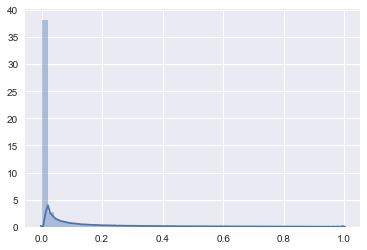

In [130]:
probs_dev = rfc.predict_proba(model_dev[features])[:,1]
probs_train = rfc.predict_proba(model_train[features])[:,1]
sns.distplot(probs_dev)

In [137]:
thresh = .3
print((probs_dev >= thresh).sum())
print(metrics.classification_report(model_dev['broke_from_party'], probs_dev >= thresh, digits=4))

26319
             precision    recall  f1-score   support

          0     0.9711    0.9713    0.9712    468404
          1     0.4885    0.4870    0.4878     26399

avg / total     0.9453    0.9454    0.9454    494803



## Try Including Some Broader Characteristics
Larger factors

In [12]:
df_members = pd.read_csv('../data/propublica/members_all.csv', encoding = 'latin1')
c1 = df_members.short_title == 'Rep.'
c2 = df_members.short_title == 'Sen.'
df_members = df_members[c1 | c2]
df_members.drop_duplicates(subset=['session', 'short_title', 'id' ,'party'], inplace=True)
df_composition = df_members.groupby(['session', 'short_title', 'party']).size().unstack()
#df_composition['majority'] = df_composition.apply(lambda x: np.argmax(x), axis = 1)
df_composition['Percent_R'] = df_composition.R / (df_composition.R + df_composition.D)
df_composition = pd.concat([df_composition, 
                            df_members.groupby(['session', 'short_title']).votes_with_party_pct.describe().unstack()], 
                           axis = 1)
df_composition.drop(['D', 'I','ID','R','count'], axis = 1, inplace = True)
df_composition.reset_index(inplace = True)
#party_composition = df_composition.to_dict(orient='index')

In [179]:
df_members[df_members.session >= 105 ].id.unique().shape

(1245,)

In [154]:
model_test.head()

,member_id,party,vote_position,congress,roll_call,chamber,session,bill_id,majority_pos_rep,majority_pos_dem,broke_from_party,m_amendment_votes,m_bill_info,m_bill_involvement,m_ideology,m_member_demos,m_pac_general,m_pac_industry,m_votes_party
full_set_id,,,,,,,,,,,,,,,,,,,
291774,B000229,R,Yes,105.0,8.0,House,1.0,hres31-105,Yes,Yes,0,-1.0,0.540158,-1.0,0.470703,0.509497,-1.0,-1.0,0.400173
291777,B000403,R,Yes,105.0,8.0,House,1.0,hres31-105,Yes,Yes,0,-1.0,0.540158,-1.0,0.282982,0.585382,-1.0,-1.0,0.400173
291784,B000556,R,Yes,105.0,8.0,House,1.0,hres31-105,Yes,Yes,0,-1.0,0.540158,-1.0,0.678277,0.496245,-1.0,-1.0,0.400173
291790,B000619,D,Yes,105.0,8.0,House,1.0,hres31-105,Yes,Yes,0,-1.0,0.540158,-1.0,0.269928,0.371170,-1.0,-1.0,0.400173
291813,C000243,R,Yes,105.0,8.0,House,1.0,hres31-105,Yes,Yes,0,-1.0,0.540158,-1.0,0.344057,0.458935,-1.0,-1.0,0.400173


In [13]:
df_composition.rename(columns={'session': 'congress', 'short_title': 'chamber'}, inplace = True)
df_composition['chamber'] = df_composition.chamber.replace({'Sen.': 'Senate', 'Rep.': 'House'})

In [14]:
new_features = [x for x in df_composition.columns if x not in ['congress', 'chamber']] + ['is_R']
dfs = [model_train, model_dev, model_test]
model_train, model_dev, model_test = map(lambda x: pd.merge(x, df_composition, how = 'left', on = ['congress', 'chamber']), dfs)
model_train['is_R'] = model_train.party == 'R'
model_dev['is_R'] = model_dev.party == 'R'
model_test['is_R'] = model_test.party == 'R'

In [16]:
rfc = RandomForestClassifier(**params)
rfc.fit(model_train[features + new_features], model_train['broke_from_party'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.5, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=200, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

C:\Users\Steve\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


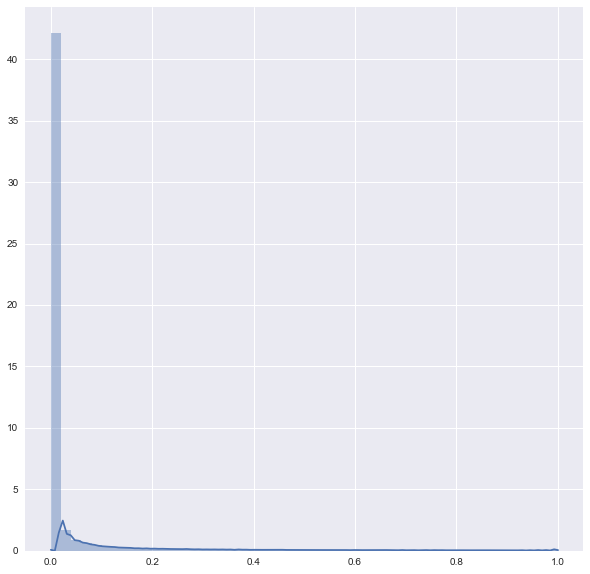

In [17]:
probs_dev = rfc.predict_proba(model_dev[features + new_features])[:,1]
probs_train = rfc.predict_proba(model_train[features + new_features])[:,1]
sns.distplot(probs_dev)

In [23]:
thresh = .24
print((probs_dev >= thresh).sum())
print(metrics.classification_report(model_dev['broke_from_party'], probs_dev >= thresh, digits=4))

26276
             precision    recall  f1-score   support

          0     0.9684    0.9687    0.9685    468404
          1     0.4412    0.4391    0.4401     26399

avg / total     0.9403    0.9404    0.9403    494803

